### Checking precipitable water to get the first impression

In [1]:
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
%matplotlib inline  

warnings.filterwarnings('ignore')

In [4]:
# creatiing my own colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridis = cm.get_cmap('PRGn_r', 256)
newcolors = viridis(np.linspace(0,1,11))
maxcolor = np.array([3/256, 54/256, 130/256, 1])
mincolor = np.array([256/256, 256/256, 256/256, 1])
#newcolors[-1:, :] = maxcolor
newcolors[:1,:] = mincolor
newcmp = ListedColormap(newcolors)

In [5]:
opath='/project/meteo/w2w/B6/icon/naturerun-toy/spinnup/'
ofiles=['param','shallow','stochastic_shallow','explicit']

hist_bin=np.linspace(0,70,71)
yy=hist_bin[1:]+hist_bin[:-1]
yy=0.5*yy

#create the temporal evolution of PW distribution for the 40-km run
tqv_40km=xr.open_dataset(opath+'tqv-global1.nc')['tqv']
tqv_40km=tqv_40km.sel(lat=slice(-20.,20.))
nt_40km=tqv_40km.shape[0]
pw_freq_40km=np.zeros((nt_40km, 70))

for t in range(nt_40km):
    pw_freq_40km[t,:], bin_edges=np.histogram(tqv_40km[t,...], bins=hist_bin, density=True)

In [6]:
#create the temporal evolution of PW distribution for the 26-km run
tqv_26km=xr.open_dataset(opath+'tqv-global2.nc')['tqv']
tqv_26km=tqv_26km.sel(lat=slice(-20.,20.))
tqv_26km=tqv_26km.where(tqv_26km.time < np.datetime64('2020-07-31T00'), drop=True)
nt_26km=tqv_26km.shape[0]
pw_freq_26km=np.zeros((nt_26km, 70))

for t in range(nt_26km):
    pw_freq_26km[t,:], bin_edges=np.histogram(tqv_26km[t,...], bins=hist_bin, density=True)

In [7]:
#create the temporal evolution of PW distribution for the 13-km run
for i, od in enumerate(ofiles[:1]):
    tqv_13km=xr.open_dataset(opath+od+'/tqv.nc')['tqv']
    tqv_13km=tqv_13km.sel(lat=slice(-20.,20.))
    #not including the last time step
    #as this time step overlaps with the first time step of high-res runs
    tqv_13km=tqv_13km.where(tqv_13km.time < tqv_13km.time[-1], drop=True) 
    nt_13km=tqv_13km.shape[0]
    pw_freq_13km=np.zeros((nt_13km, 70))
    
    for t in range(nt_13km):
        pw_freq_13km[t,:], bin_edges=np.histogram(tqv_13km[t,...], bins=hist_bin, density=True)

In [8]:
#maybe better to run a bash script to create a single file?
#tqv_5km=xr.open_dataset('data/tqv-5km-param.nc')['tqv']
tqv_5km=xr.open_dataset('data/tqv-5km-explicit.nc')['tqv']
tqv_5km=tqv_5km.sel(lat=slice(-20.,20.))
nt_5km=tqv_5km.shape[0]
pw_freq_5km=np.zeros((nt_5km, 70))

for t in range(nt_5km):
    pw_freq_5km[t,:], bin_edges=np.histogram(tqv_5km[t,...], bins=hist_bin, density=True)

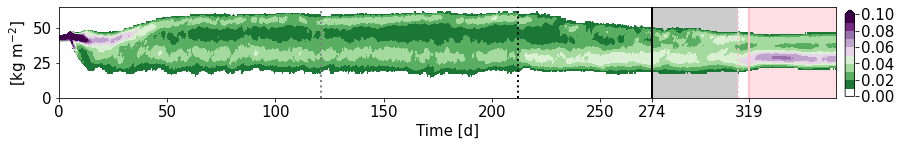

In [9]:
#plotting
fs = 15
plt.rcParams.update({'font.size': fs})

fig = plt.figure(figsize=(13,2))
plt.subplots_adjust(left=0.08, right=0.91, bottom=0.35, top=0.98)

#concatenate all arrays
pw_freq=np.concatenate((pw_freq_40km, pw_freq_26km, pw_freq_13km, pw_freq_5km), axis=0)
time=np.concatenate((tqv_40km.time, tqv_26km.time, tqv_13km.time, tqv_5km.time))
#initial time as day 0
time = time - np.datetime64('2020-01-01T00')
time = time.astype('float')
time = time*1e-9/86400.

it_5km = int(time[-1])-40
plt.axvspan(it_5km, it_5km+40, facecolor='pink', alpha=0.5, zorder=0)
plt.axvspan(274, 274+40, facecolor='black', alpha=0.2, zorder=0)

#to bring the freq distribution front
pw_freq = np.where(pw_freq > 0.01, pw_freq, np.nan)

im=plt.contourf(time,yy,pw_freq.transpose(), cmap=newcmp,
                levels=np.linspace(0,10,11)*0.01, extend='max')

plt.vlines(time[nt_40km+nt_26km],0, 70, color='black', linewidth=2, ls='dotted')
plt.vlines(time[nt_40km], 0, 70, color='gray',linewidth=2, ls='dotted')
plt.vlines(274, 0, 70, color='black', linewidth=2)
plt.vlines(time[nt_40km+nt_26km+nt_13km], 0, 70, color='pink',linewidth=2, ls='dotted')
plt.vlines(it_5km, 0, 70, color='pink',linewidth=2)
plt.ylim(0,65)
plt.xticks([0,50,100,150,200,250,274,it_5km])

plt.xlabel('Time [d]')
plt.ylabel('[kg m'+r'$^{-2}$'+']')
cbaxes = fig.add_axes([0.92, 0.36, 0.01, 0.6]) #[left, bottom, width, height]
cb=fig.colorbar(im,cax = cbaxes)
#plt.savefig('../fig/pw_evolution.png', dpi=150)

### Create an animation

In [2]:
from matplotlib.ticker import MultipleLocator
from enstools.io import read
flists=['param','shallow','stochastic_shallow','explicit','P5','E5']

fs=15
nn=15

for it in range(320):
    fig, axs = plt.subplots(6,1,figsize=(10,10)) # 
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.03)

    clev=np.linspace(0,100,101)
    title = ['(a) P13','(b) E13','(c) S13','(d) SS13','(e) P5','(f) E5']
    isel=361
    axs[-1].vlines(0,1,1, colors='#FEB2AA', label='35 mm/d')
    #axs[-1].vlines(0,1,1, colors='#FD7280', label='50 mm/d')
    axs[-1].vlines(0,1,1, colors='#FD3464', label='70 mm/d')
    
    for i, od in enumerate(flists):
        
        if od == 'P5':
            opath='/archive/meteo/w2w-p2/B6/high_resolution/param'
            tqv = xr.open_dataset('%s/nature_run_DOM01_ML_%04d.nc' % (opath, it*3+73))['tqv']
            
            tot_prec1 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, it*3+73))['tot_prec']
            tot_prec2 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, (it+1)*3+73))['tot_prec']
            
            itime=np.datetime64('2020-11-10T00')
            
        elif od == 'E5':
            opath='/archive/meteo/w2w-p2/B6/high_resolution/output'
            tqv = read('%s/nature_run_DOM01_ML_%04d.nc' % (opath,it*3+121))['tqv']
            
            tot_prec1 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, it*3+121))['tot_prec']
            tot_prec2 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, (it+1)*3+121))['tot_prec']
            
            itime=np.datetime64('2020-11-10T00')
            
        else:
            opath='/archive/meteo/w2w-p2/B6/natureruns_new/'
            tqv = xr.open_dataset('%s%s/nature_run_DOM01_ML_%04d.nc' % (opath, od, (it*3+1) ))['tqv']
            
            tot_prec1 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, it*3+1))['tot_prec']
            tot_prec2 = xr.open_dataset('data/%s/obs_DOM01_reg_ML_tot_prec_%04d.nc' % (od, (it+1)*3+1))['tot_prec']

            itime=np.datetime64('2020-10-01T00')
            
        time1=tot_prec1.time.values - itime
        #time2=tot_prec2.time.values - itime
        
        prec = tot_prec2 - tot_prec1.values
        prec = prec*24./3 #mm/d
        
        im1=tqv[0,:,:].sel(lat=slice(-20,20)).plot.contourf(ax=axs[i], levels=np.linspace(0,60,61), cmap='Blues',
                                     add_labels=False, label=False, add_colorbar=False)
        cs=axs[i].contour(prec.lon, prec.lat, prec[0,...], linewidths=1,
                          levels=[35,70], colors=['#FEB2AA','#FD3464'])
                           #levels=[10,50,100], colors=['#FEB2AA','#FD7280','#FD3464'])
        
        axs[i].set_ylabel(title[i], fontsize=fs)
        
        if i == 0:
            t_time = tqv.time[0] - np.datetime64('2020-10-01T00')
            t_time = float(t_time.values)*1e-9/86400.
            axs[0].set_title('Day %.2f' % t_time, fontsize=15)

    for ax in fig.get_axes():
        ax.label_outer()

    ythicks = ['15\u00b0S','0\u00b0N','15\u00b0N']
    for ax in axs.flat:
        ax.tick_params(axis="y",labelsize=fs)
        ax.set_ylim(-20.,20.)
        ax.set_yticks([-15,0,15])
        ax.yaxis.set_minor_locator(MultipleLocator(5))
        ax.set_xticks([-180,-135,-90,-45,0,45,90,135,180])
        ax.set_yticklabels(ythicks)

    #axs[0].set_title("Total cloud cover", fontsize = fs)

    axs[-1].set_xticks([-180,-90,0,90,180])
    axs[-1].set_xticklabels(['180\u00b0W','90\u00b0W','0\u00b0','90\u00b0E','180\u00b0E'])
    axs[-1].tick_params(axis="x",labelsize=fs)
    axs[-1].xaxis.set_minor_locator(MultipleLocator(45))

    cbaxes1 = fig.add_axes([0.08, 0.04, 0.6, 0.015]) #[left, bottom, width, height]
    
    cticks=[0, 10, 20, 30, 40, 50, 60]    
    cb1=fig.colorbar(im1,cax = cbaxes1, ticks=cticks, orientation='horizontal')
    cb1.ax.tick_params(labelsize=fs)
    fig.text(0.68, 0.04, '[kg m'+r'$^{-2}$'+']', fontsize=fs*0.9)
        
    axs[-1].legend(loc='lower right', bbox_to_anchor=(1,-0.75), frameon=False, fontsize=fs*0.9)
    #fig.patch.set_facecolor('white')
    plt.savefig('../gif_2/pw-%03d.png' % it, dpi =100,facecolor='white')
    plt.clf()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>